### Importing Libraries

In [12]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    BatchNormalization,
    Dropout
)
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
tf.random.set_seed(42)

### Constants

In [13]:
img_height, img_width = 128, 128
batch_size = 32
num_classes = 124
data_dir = os.path.join(os.getcwd(), "gei/")

### Training Data Augmentation

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.15,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    brightness_range=[0.8, 1.2],
    channel_shift_range=10,
    zoom_range=[0.8, 1.2],
)

### Testing Data Augmentation

In [15]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.15)

### Load and split data into training and testing sets

In [16]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=42,
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=42,
)

Found 11555 images belonging to 124 classes.
Found 1967 images belonging to 124 classes.


### Load pre-trained ResNet50 without top layers

In [17]:
base_model = InceptionV3(
    weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3)
)

### Add custom classification layers

In [18]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.003))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.003))(x)
predictions = Dense(num_classes, activation='linear',
                    kernel_regularizer=l2(0.003))(x)

### Create the model

In [19]:
model = Model(inputs=base_model.input, outputs=predictions)

### Fine Tune the layers

In [20]:
for layer in model.layers:
    layer.trainable = True

### Compile the model

In [21]:
model.compile(
    optimizer=RMSprop(
        learning_rate=1e-4,
        rho=0.9,
        momentum=0.0,
        epsilon=1e-07,
        centered=False,
        name="RMSprop",
    ),
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

### Train the model

In [22]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator)

Epoch 1/50
362/362 [==============================] - 148s 381ms/step - loss: 12.9623 - accuracy: 0.0080 - val_loss: 12.2656 - val_accuracy: 0.0142
Epoch 2/50
362/362 [==============================] - 136s 374ms/step - loss: 12.2677 - accuracy: 0.0128 - val_loss: 11.4602 - val_accuracy: 0.0244
Epoch 3/50
362/362 [==============================] - 135s 373ms/step - loss: 11.5074 - accuracy: 0.0206 - val_loss: 10.8491 - val_accuracy: 0.0320
Epoch 4/50
362/362 [==============================] - 135s 372ms/step - loss: 10.7520 - accuracy: 0.0268 - val_loss: 9.9745 - val_accuracy: 0.0641
Epoch 5/50
362/362 [==============================] - 136s 375ms/step - loss: 9.9073 - accuracy: 0.0525 - val_loss: 9.2816 - val_accuracy: 0.1083
Epoch 6/50
362/362 [==============================] - 135s 373ms/step - loss: 9.1594 - accuracy: 0.0871 - val_loss: 8.6650 - val_accuracy: 0.1154
Epoch 7/50
362/362 [==============================] - 135s 372ms/step - loss: 8.4426 - accuracy: 0.1242 - val_loss: 7

### Evaluate model on training set

In [23]:
train_loss, train_accuracy = model.evaluate(train_generator)
print(f"Training accuracy: {train_accuracy}")

362/362 [==============================] - 78s 214ms/step - loss: 1.0541 - accuracy: 0.9595
Training accuracy: 0.9594980478286743


### Evaluate model on testing set

In [24]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Testing accuracy: {test_accuracy}")

62/62 [==============================] - 6s 92ms/step - loss: 1.6975 - accuracy: 0.7900
Testing accuracy: 0.790035605430603


### Save the model

In [25]:
model.save('InceptionV3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model Summary

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 63, 63, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_96 (Ba  (None, 63, 63, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 63, 63, 32)           0         ['batch_normalization_96

### Plot Training & Validation Accuracy

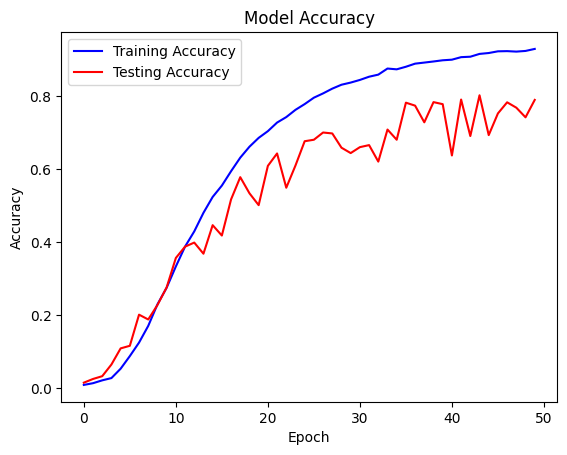

In [27]:
plt.plot(history.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(history.history['val_accuracy'],
         color='red', label='Testing Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Plot Training and Validation Loss

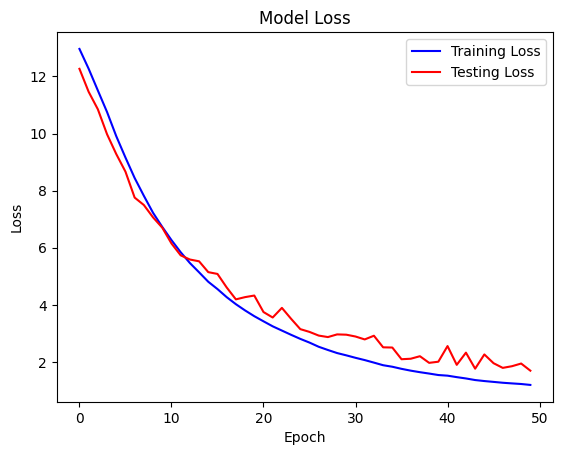

In [28]:
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'],
         color='red', label='Testing Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()